In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
import gc

In [2]:
labels_list = ["T-shirt/top", "Trouser", "Trouser", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [7]:
def find_noisy_images(pixels, min_threshold=0.05, max_threshold=0.95):
    try:
        pixels_array = np.array(pixels).astype(float)
        pixel_density = (pixels_array != 0).mean()
        return pixel_density < min_threshold or pixel_density > max_threshold
    except Exception as e:
        print(f"Ошибка при анализе шума: {e}")
        return True

In [14]:
def find_duplicates(image_data, existing_data, similarity_threshold=0.98, batch_size=1000):
    if len(existing_data) == 0:
        return False
        
    # Нормализуем текущее изображение
    image_data_norm = normalize(image_data.reshape(1, -1)).flatten()
    
    # Обрабатываем существующие данные пакетами
    for i in range(0, len(existing_data), batch_size):
        batch = existing_data[i:i + batch_size]
        # Нормализуем batch
        batch_norm = normalize(batch)
        # Вычисляем сходство для текущего batch
        similarities = np.dot(batch_norm, image_data_norm)
        if (similarities > similarity_threshold).any():
            return True
            
    return False

In [6]:
def find_missing_values(value):
    if pd.isna(value):
        return True
    
    if isinstance(value, str):
        stripped = value.strip()
        return (not stripped or
                stripped in ['N/A', 'NA', '-', 'null', 'None'])
    
    if isinstance(value, (int, float)):
        return value == 0
    return False

In [13]:
from tqdm import tqdm


def filter_and_save_img(original_csv_path, new_csv_file, batch_size=1000):
    original_csv = pd.read_csv(original_csv_path)
    
    filtered_data = []
    
    pixel_columns = [col for col in original_csv.columns if col != 'label']

    existing_pixels = np.empty((0, len(pixel_columns)))
    
    print(f"Начало фильтрации. Всего изображений: {len(original_csv)}")
    
    for batch_start in tqdm(range(0, len(original_csv), batch_size)):
        batch = original_csv.iloc[batch_start:batch_start + batch_size]

        for _, row in batch.iterrows():
            if row[pixel_columns].apply(find_missing_values).any():
                continue

            pixels = row[pixel_columns].values

            if find_noisy_images(pixels):
                continue

            if len(existing_pixels) > 0:
                if find_duplicates(pixels, existing_pixels):
                    continue

            filtered_data.append(row)
            existing_pixels = np.vstack([pixels, existing_pixels])

            if len(filtered_data) % 1000 == 0:
                pd.DataFrame(filtered_data).to_csv(new_csv_file, index=False)

    filtered_df = pd.DataFrame(filtered_data)
    filtered_df.to_csv(new_csv_file, index=False)    
    print(f"Фильтрация завершена. Сохранено изображений: {len(filtered_df)}")
    
    return filtered_df
    

In [5]:
def analyse(original_csv_path, filtered_csv_path):
    td = pd.read_csv(original_csv_path)
    ntd = pd.read_csv(filtered_csv_path)
    
    print("\nРезультаты фильтрации:")
    print(f"Исходное кол-во изображений: {len(td)}")
    print(f"Удалено изображений: {len(td) - len(ntd)}")
    print(f"Оставшееся кол-во изображений: {len(ntd)}")
    
    if 'label' in td.columns:
        print("\n---Распределение меток---")
        print("До фильтрации:")
        print(td['label'].value_counts())
        print("\nПосле фильтрации:")
        print(ntd['label'].value_counts())

In [15]:
ntd = filter_and_save_img("fashion-mnist_train.csv", "new-fashion-mnist_train.csv")
# Анализ результатов
analyse("fashion-mnist_train.csv", "new-fashion-mnist_train.csv")

/tmp/ipykernel_3817/1136585920.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  original_csv = pd.read_csv(original_csv_path)


Начало фильтрации. Всего изображений: 58000


100%|██████████| 58/58 [05:19<00:00,  5.51s/it]


Фильтрация завершена. Сохранено изображений: 0


/tmp/ipykernel_3817/3185901833.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  td = pd.read_csv(original_csv_path)


EmptyDataError: No columns to parse from file

label
0    407
1    272
2    364
3    500
4    294
5    821
6    487
7    662
8    642
9    552
Name: count, dtype: int64


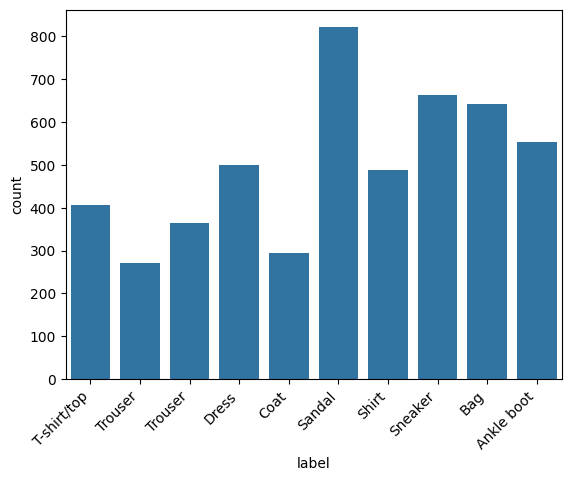

<Figure size 640x480 with 0 Axes>

In [38]:
import seaborn as sns

nTrainD = pd.read_csv("new-fashion-mnist_train.csv")
nTestD = pd.read_csv("new-fashion-mnist_test.csv")

label_counts = nTrainD['label'].value_counts().sort_index()
print(label_counts)

sns.countplot(x='label', data=nTrainD)
plt.xticks(range(len(labels_list)), labels_list, rotation=45, ha='right')
plt.show()
plt.savefig('labels.jpg')